In [1]:
import os
import tensorflow as tf
from tensorflow.python.keras import layers, losses
import matplotlib.pyplot as plt

# Data location:

In [2]:
data_location = "../data/split"
export_location = "../models/"

first_category = ["formula", "inorganic"][0]
second_category = ["name", "organic"][0]

model_name = ["", "formula-", "name-"][0] # Prefix
model_name += first_category + "-" + second_category

In [3]:
dataset_directory = os.path.join(data_location, model_name)
train_directory = os.path.join(dataset_directory, "train")
test_directory = os.path.join(dataset_directory, "test")

print("In data:", os.listdir(dataset_directory))
print("In train:", os.listdir(train_directory))
print("In test:", os.listdir(test_directory))

In data: ['test', 'train']
In train: ['formula', 'formulas-90%.txt', 'name', 'names-90%.txt']
In test: ['formula', 'formulas-10%.txt', 'name', 'names-10%.txt']


### Sample file:

In [4]:
sample_file = os.path.join(train_directory, first_category, "ab.txt")

print("Sample file:", open(sample_file).read())

Sample file: CH2(NO2)-CHF-O-CH2I



# Data collection:

In [5]:
seed = 32 # Random seed for data shuffling and transformations
validation_split = 0.2 # Proportion of train data used to validate the model

In [6]:
raw_train_data_source = tf.keras.preprocessing.text_dataset_from_directory(
    train_directory,
    subset = "training",
    seed = seed,
    validation_split = validation_split,
)

Found 44599 files belonging to 2 classes.
Using 35680 files for training.


In [7]:
raw_validation_data_source = tf.keras.preprocessing.text_dataset_from_directory(
    train_directory,
    subset = "validation",
    seed = seed,
    validation_split = validation_split,
)

Found 44599 files belonging to 2 classes.
Using 8919 files for validation.


In [8]:
raw_test_data_source = tf.keras.preprocessing.text_dataset_from_directory(
    test_directory,
)

Found 4954 files belonging to 2 classes.


# Data pre-processing:

In [9]:
# Registers data_standarization

# TODO use model class to avoid code repetition

@tf.keras.utils.register_keras_serializable()
def data_standardization(input_data): # CH3-CH=CH-CH(NO2)Br
    input_data = tf.strings.lower(input_data) # ch3-ch=ch-ch(no2)br
    input_data = tf.strings.regex_replace(input_data, "[^a-zà-ú]", ' ') # ch  ch ch ch no  br
    return tf.strings.regex_replace(input_data, "\s+", ' ') # ch ch ch ch no br

In [10]:
max_features = 2048 # Sets a boundary for len(vectorize_layer.get_vocabulary())

In [11]:
sequence_length = 16 # Vectorized string's dimension

vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    output_mode = "int",
    max_tokens = max_features,
    standardize = data_standardization,
    output_sequence_length = sequence_length
)

In [12]:
# Makes a text-only dataset (without labels), then calls adapt
train_text = raw_train_data_source.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [13]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [14]:
# Retrieves a batch of 32 reviews and labels from the dataset
text_batch, label_batch = next(iter(raw_train_data_source))
first_review, first_label = text_batch[0], label_batch[0]

print("Review:", first_review)
print("Label:", raw_train_data_source.class_names[first_label])
print("Vectorized review:", vectorize_text(first_review, first_label))

Review: tf.Tensor(b'1-fluoro-1-yodopropil etinil \xc3\xa9ter\r\n', shape=(), dtype=string)
Label: name
Vectorized review: (<tf.Tensor: shape=(1, 16), dtype=int64, numpy=
array([[16, 63, 62,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)


In [15]:
print("Vocabulary size:", len(vectorize_layer.get_vocabulary()))

Vocabulary size: 2048


In [16]:
print("Vocabulary:", sorted(vectorize_layer.get_vocabulary(), key = len))

Vocabulary: ['', 'c', 'o', 'i', 'f', 'v', 'h', 'n', 'p', 's', 'u', 'k', 'b', 'w', 'y', 'l', 'm', 'ch', 'de', 'no', 'br', 'cl', 'oh', 'nh', 'ol', 'en', 'ii', 'iv', 'cf', 'ci', 'vi', 'co', 'in', 'cn', 'so', 'io', 'po', 'pb', 'ni', 'au', 'sn', 'fe', 'pt', 'bi', 'ti', 'cr', 'mn', 'hg', 'cu', 'as', 'bo', 'si', 'sb', 'se', 'pd', 'te', 'os', 'mo', 'al', 'na', 'ta', 'ag', 'tl', 'nb', 'rb', 'mg', 'ba', 'ga', 'li', 'cd', 'be', 'ca', 'zn', 'sr', 'ra', 'zr', 'sc', 're', 'la', 'ir', 'ho', 'cs', 'ce', 'rh', 'ru', 'fr', 'sm', 'pr', 'am', 'wo', 'tc', 'th', 'hf', 'vo', 'pu', 'eu', 'np', 'tb', 'dy', 'cm', 'bk', 'yb', 'tm', 'pa', 'lu', 'gd', 'er', 'uf', 'ph', 'nd', 'if', 'di', 'wh', 'vh', 'vf', 'uh', 'sf', 'nf', 'ac', 'vs', 'us', 'pm', 'pi', 'hs', 'yn', 'yi', 'yh', 'yf', 'ws', 'wp', 'wn', 'wi', 'wf', 'vn', 'vc', 'up', 'uo', 'ui', 'ts', 'sg', 'rn', 'rg', 'chf', 'iii', 'chi', 'cbr', 'ccl', 'eno', 'bis', 'ona', 'ino', 'cho', 'vii', 'clo', 'bro', 'but', 'oro', 'teo', 'seo', 'mno', 'aso', 'cro', 'sbo', 'sio',

In [17]:
train_data_source = raw_train_data_source.map(vectorize_text)
validation_data_source = raw_validation_data_source.map(vectorize_text)
test_data_source = raw_test_data_source.map(vectorize_text)

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # ??

train_data_source = train_data_source.cache().prefetch(buffer_size = AUTOTUNE)
validation_data_source = validation_data_source.cache().prefetch(buffer_size = AUTOTUNE)
test_data_source = test_data_source.cache().prefetch(buffer_size = AUTOTUNE)

# Model creation:

In [19]:
embedding_dim = 2 ** 10  # 2 ** 10 seems to be optimal, 2 ** 4 was default

In [20]:
def create_model ():
  model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.Dense(256, activation = "relu"),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1),
  ])
  
  model.compile(
    optimizer = "adam",
    metrics = tf.metrics.BinaryAccuracy(threshold = 0.0),
    loss = losses.BinaryCrossentropy(from_logits = True),
  )
  
  return model

model = create_model()
  

### Training:

In [21]:
epochs = 5

history = model.fit(
    epochs = epochs,
    x = train_data_source,
    validation_data = validation_data_source,
)

Epoch 1/5
1115/1115 [==============================] - 67s 60ms/step - loss: 0.0575 - binary_accuracy: 0.9724 - val_loss: 0.0291 - val_binary_accuracy: 0.9826
Epoch 2/5
1115/1115 [==============================] - 40s 36ms/step - loss: 0.0187 - binary_accuracy: 0.9875 - val_loss: 0.0282 - val_binary_accuracy: 0.9775
Epoch 3/5
1115/1115 [==============================] - 41s 37ms/step - loss: 0.0175 - binary_accuracy: 0.9881 - val_loss: 0.0282 - val_binary_accuracy: 0.9775
Epoch 4/5
1115/1115 [==============================] - 39s 35ms/step - loss: 0.0174 - binary_accuracy: 0.9881 - val_loss: 0.0283 - val_binary_accuracy: 0.9774
Epoch 5/5
1115/1115 [==============================] - 45s 40ms/step - loss: 0.0174 - binary_accuracy: 0.9881 - val_loss: 0.0283 - val_binary_accuracy: 0.9775


### Compiling:

In [22]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation("sigmoid")
])

export_model.compile(
    optimizer = "adam", 
    metrics = ["accuracy"],
    loss = losses.BinaryCrossentropy(from_logits = False), 
)

# Model evaluation:

### Using test data:

In [23]:
loss, accuracy = model.evaluate(test_data_source)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

155/155 [==============================] - 10s 59ms/step - loss: 0.0118 - binary_accuracy: 0.9998
Test loss: 0.011814615689218044
Test accuracy: 0.9997981190681458


### Using raw test data:

In [24]:
loss, accuracy = export_model.evaluate(raw_test_data_source)

print("Raw test loss:", loss)
print("Raw test accuracy:", accuracy)

155/155 [==============================] - 2s 12ms/step - loss: 0.0118 - accuracy: 0.9998
Raw test loss: 0.011814617551863194
Raw test accuracy: 0.9997981190681458


### Accuracy graph:

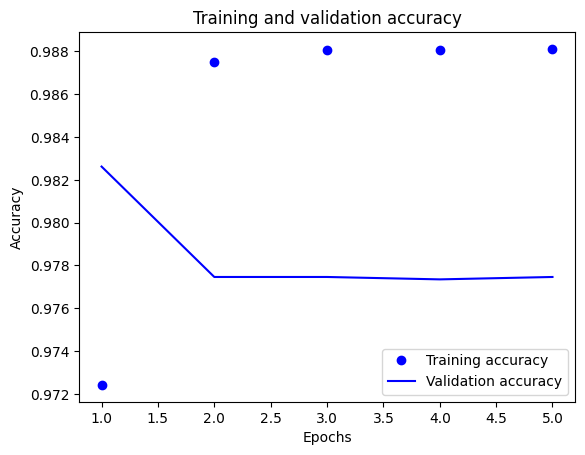

In [25]:
history_dict = history.history
history_dict.keys()

accuracy = history_dict["binary_accuracy"]
validation_accuracy = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
validation_loss = history_dict["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy") # Blue dots
plt.plot(epochs, validation_accuracy, "b", label = "Validation accuracy") # Blue line
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

### Loss graph:

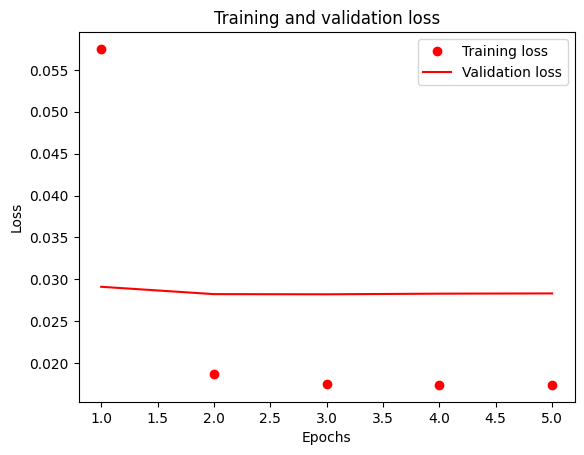

In [26]:
plt.plot(epochs, loss, "ro", label = "Training loss") # Red dots
plt.plot(epochs, validation_loss, "r", label = "Validation loss") # Red line
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Model exportation:

In [27]:
export_model.save(export_location + model_name + "-model", save_format='tf')

INFO:tensorflow:Assets written to: ../models/formula-name-model\assets


INFO:tensorflow:Assets written to: ../models/formula-name-model\assets


# Model predictions:

In [28]:
def predict_categories(examples):
    for example in examples:
        prediction = export_model.predict([example])[0][0] * 100
        category = first_category if prediction < 50 else second_category
        print(category, "(" + "%.2f" % prediction + "%):", example)

### Inorganic formulas:

In [29]:
inorganic_formulas = [
    "mn2(Hpo3)3",
    "NaCl",
    "H2SO4",
    "CL203",
    "znCO2",
    "H2O",
    "FeNA2",
    "G2S2O5",
    "Cl2O⁺H2O",
]

predict_categories(inorganic_formulas)

1/1 [==============================] - 0s 136ms/step
formula (0.00%): mn2(Hpo3)3
1/1 [==============================] - 0s 33ms/step
name (52.61%): NaCl
1/1 [==============================] - 0s 35ms/step
formula (0.00%): H2SO4
1/1 [==============================] - 0s 39ms/step
formula (0.01%): CL203
1/1 [==============================] - 0s 37ms/step
name (52.61%): znCO2
1/1 [==============================] - 0s 36ms/step
formula (0.00%): H2O
1/1 [==============================] - 0s 35ms/step
name (52.61%): FeNA2
1/1 [==============================] - 0s 34ms/step
formula (2.86%): G2S2O5
1/1 [==============================] - 0s 34ms/step
formula (0.00%): Cl2O⁺H2O


### Inorganic names:

In [30]:
inorganic_names = [
    "arsenito diacido de sodio",
    "hipoclorito de sodio",
    "potasiuro de boro",
    "cloruro de sodio",
    "acido disulfuroso",
    "sulfurico"
]

predict_categories(inorganic_names)

1/1 [==============================] - 0s 34ms/step
name (100.00%): arsenito diacido de sodio
1/1 [==============================] - 0s 36ms/step
name (100.00%): hipoclorito de sodio
1/1 [==============================] - 0s 37ms/step
name (100.00%): potasiuro de boro
1/1 [==============================] - 0s 36ms/step
name (100.00%): cloruro de sodio
1/1 [==============================] - 0s 37ms/step
name (54.59%): acido disulfuroso
1/1 [==============================] - 0s 36ms/step
name (52.61%): sulfurico


### Organic formulas:

In [31]:
organic_formulas = [
    "Ch3ChCh(Ch3ChCh3)ChCh",
    "H3C-CH2",
    "H3C-CH2-CH2",
    "h c c h",
    "h c c h h c c h",
    "CH3-CO-O-CH2-CH3",
    "CH3-CH2-O-CH2-CH3",
    "CH3-CH2-CH=CH-COOH",
    "ch3chch2ch(ch2ch2ch3)cooh",
    "ch3(Ch3)Chch2Ch(Ch3)Ch2Ch(Ch2Ch2Ch3)Ch3",
]

predict_categories(organic_formulas)

1/1 [==============================] - 0s 34ms/step
formula (0.00%): Ch3ChCh(Ch3ChCh3)ChCh
1/1 [==============================] - 0s 39ms/step
formula (0.00%): H3C-CH2
1/1 [==============================] - 0s 34ms/step
formula (0.00%): H3C-CH2-CH2
1/1 [==============================] - 0s 36ms/step
formula (0.00%): h c c h
1/1 [==============================] - 0s 38ms/step
formula (0.00%): h c c h h c c h
1/1 [==============================] - 0s 38ms/step
formula (0.00%): CH3-CO-O-CH2-CH3
1/1 [==============================] - 0s 38ms/step
formula (0.00%): CH3-CH2-O-CH2-CH3
1/1 [==============================] - 0s 37ms/step
formula (0.00%): CH3-CH2-CH=CH-COOH
1/1 [==============================] - 0s 38ms/step
formula (0.00%): ch3chch2ch(ch2ch2ch3)cooh
1/1 [==============================] - 0s 38ms/step
formula (0.00%): ch3(Ch3)Chch2Ch(Ch3)Ch2Ch(Ch2Ch2Ch3)Ch3


### Organic names:

In [32]:
organic_names = [
    "arsano",
    "benceno",
    "naftaleno",
    "2-cloropentanato",
    "cloruro de propilo",
    "di 2-cloropentanil éter",
    "2-bromo-2-cloropropano",
    "metanoato de isopropilo",
    "orto-difenilciclohexano",
    "2-bromo-2-cloropropil yododecil éter",
    "3-cloro-2-fluoro-hexa-1,3-dien-5-in-1-ona",
    "4-amino-2,6,6-tricloro-7,7-difluoro-89-metil-3-nitro-1,1-diyodononaconta-1,3-dien-5-ona",
]

predict_categories(organic_names)

1/1 [==============================] - 0s 36ms/step
name (52.61%): arsano
1/1 [==============================] - 0s 37ms/step
name (99.98%): benceno
1/1 [==============================] - 0s 35ms/step
name (52.61%): naftaleno
1/1 [==============================] - 0s 36ms/step
name (52.61%): 2-cloropentanato
1/1 [==============================] - 0s 35ms/step
name (100.00%): cloruro de propilo
1/1 [==============================] - 0s 35ms/step
name (100.00%): di 2-cloropentanil éter
1/1 [==============================] - 0s 39ms/step
name (100.00%): 2-bromo-2-cloropropano
1/1 [==============================] - 0s 37ms/step
name (100.00%): metanoato de isopropilo
1/1 [==============================] - 0s 37ms/step
name (54.59%): orto-difenilciclohexano
1/1 [==============================] - 0s 36ms/step
name (100.00%): 2-bromo-2-cloropropil yododecil éter
1/1 [==============================] - 0s 38ms/step
name (100.00%): 3-cloro-2-fluoro-hexa-1,3-dien-5-in-1-ona
1/1 [=================